In [1]:
%load_ext autoreload
%autoreload 2

# Setup and Imports

In [2]:
from gcn import GCN
from gat import GAT
from loss import CrossEntropyLoss
import torch
import networkx as nx
import torch.nn.functional as F

# Gradient Testing for CrossEntropyLoss, GCN and GAT (Manual vs Autograd)

In [3]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt.double(), t.grad.double())
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [20]:
generator = torch.Generator()

H_random = torch.rand(128,128, generator=generator)
H_random.requires_grad = True
A_random = torch.randint(0, 2, (128,128), generator=generator) * 1.0
y_random = torch.randint(0, 17, (128,), generator=generator)

In [5]:
CE = CrossEntropyLoss()

In [21]:
H_random.grad = None
loss = CE.forward(H_random,y_random)
dloss = CE.backward(1)
loss.retain_grad()
loss.backward()
cmp("dloss", dloss, H_random)


dloss           | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
gcn = GCN(128, 20, generator=generator)

parametersGCN = [H_random, gcn.W1, gcn.W2,gcn.b]

for p in parametersGCN:
    p.requires_grad = True

In [24]:
for p in parametersGCN:
    p.grad = None

logits = gcn.forward(H_random, A_random)
out = torch.sum(logits)
dH_GCN, dW1_GCN, dW2_GCN, db_GCN  = gcn.backward(torch.ones_like(logits))

out.backward()

cmp("H", dH_GCN, H_random)
cmp("W1", dW1_GCN, gcn.W1)
cmp("W2", dW2_GCN, gcn.W2)
cmp("b", db_GCN, gcn.b)

H               | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b               | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
gat = GAT(128, 20, num_heads=10, concat=True, skip = True, generator=generator)

parametersGAT = [H_random, gat.W, gat.b, gat.attention, gat.skip_proj]

for p in parametersGAT:
    p.requires_grad = True

In [27]:
for p in parametersGAT:
    p.grad = None


logits = gat.forward(H_random, A_random)
out = torch.sum(logits)
dH_GAT, dW_GAT, db_GAT, dattention_GAT, dskip_proj_GAT = gat.backward(torch.ones_like(logits))

out.backward()

cmp('H', dH_GAT, H_random)
cmp('W', dW_GAT, gat.W)
cmp('b', db_GAT, gat.b)
cmp('attention', dattention_GAT, gat.attention)
cmp('skip_proj', dskip_proj_GAT, gat.skip_proj)

H               | exact: True  | approximate: True  | maxdiff: 0.0
W               | exact: True  | approximate: True  | maxdiff: 0.0
b               | exact: True  | approximate: True  | maxdiff: 0.0
attention       | exact: True  | approximate: True  | maxdiff: 0.0
skip_proj       | exact: True  | approximate: True  | maxdiff: 0.0


# Graph Data Preparation (Karate Club Dataset)

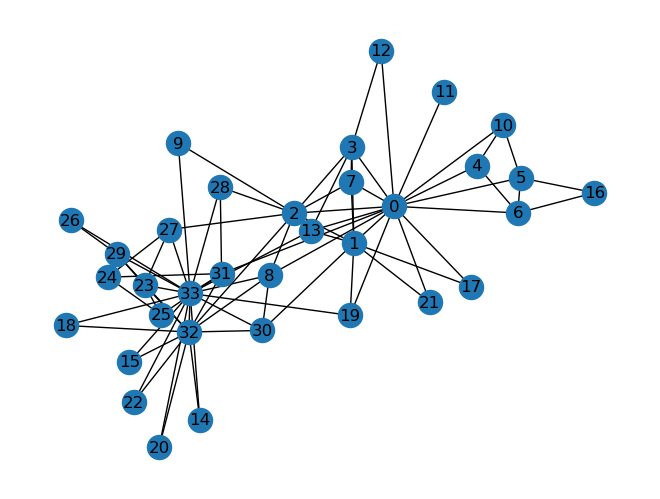

In [28]:
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)


In [29]:
A = nx.adjacency_matrix(G, weight = None)
A = torch.tensor(A.toarray(), dtype=torch.float32)


V = G.nodes
V = F.one_hot(torch.arange(len(V))) * 1.0

y = []
for node in G.nodes(data=True):
    if node[1]['club'] == "Mr. Hi":
        y.append(0)
    else:
       y.append(1)

y = torch.tensor(y)



In [30]:
import matplotlib.pyplot as plt
import time
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    h = h.detach().cpu().numpy()
    h[h == -0.0] = 0.0
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                f'Training Accuracy: {accuracy*100:.2f}% \n'),
                fontsize=16)
    plt.show()

# Training a 2-Layer GCN

In [ ]:
layersGCN = [
    GCN(34, 8, generator=generator),
    GCN(8, 2, generator=generator)
    ]

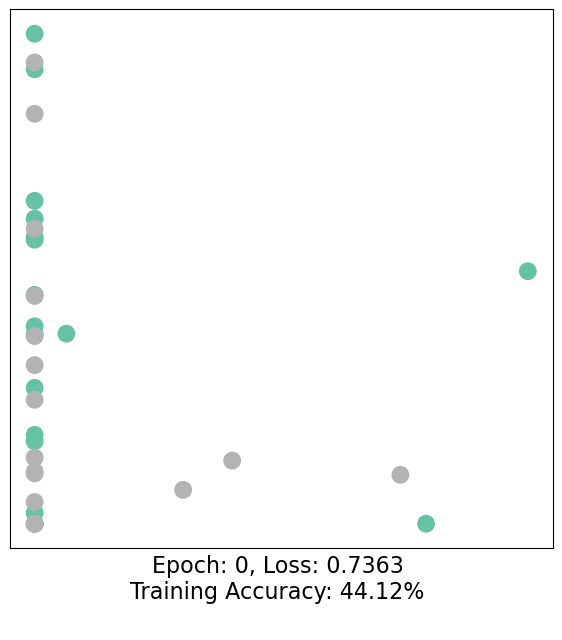

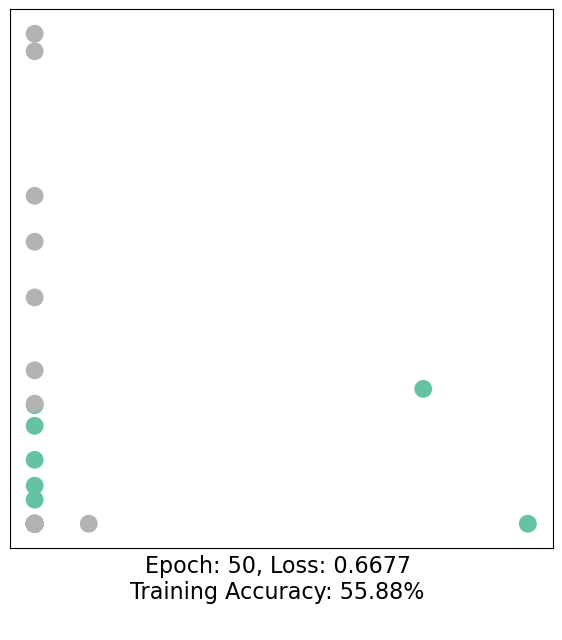

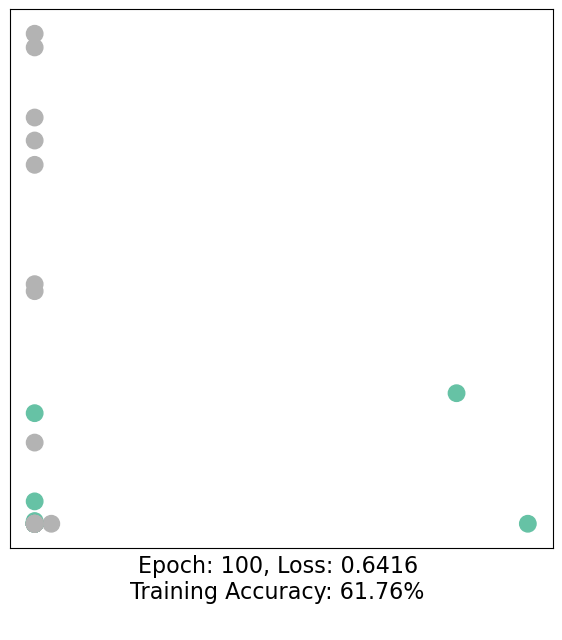

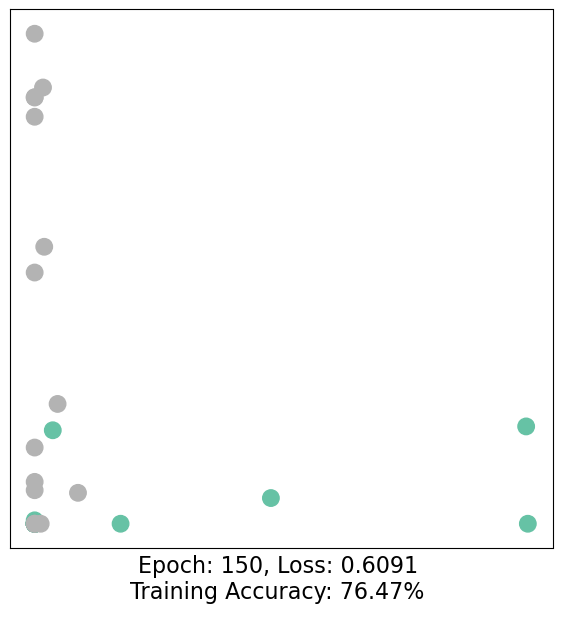

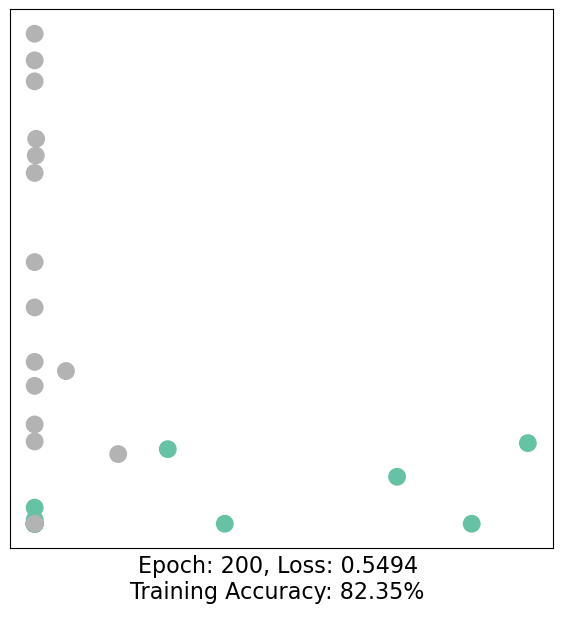

In [19]:
lr = 0.1
epochs = 250
CE = CrossEntropyLoss()

def train():
        for i in range(epochs):
            out0 = layersGCN[0].forward(V, A)
            logits = layersGCN[1].forward(out0, A)
            loss = CE.forward(logits, y)

            dlogits = CE.backward(1)
            dH1, dW11, dW12, db1 = layersGCN[1].backward(dlogits)
            dH0, dW01, dW02, db0 = layersGCN[0].backward(dH1)

            layersGCN[1].W1 -= lr * dW11
            layersGCN[1].W2 -= lr * dW12
            layersGCN[1].b -= lr * db1

            layersGCN[0].W1 -= lr * dW01
            layersGCN[0].W2 -= lr * dW02
            layersGCN[0].b -= lr * db0

            acc = torch.mean((torch.argmax(logits, dim=1) == y).float())
            #print(f"Epoch {i+1}, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")
            if i % 50 == 0:
                visualize(logits, color=y, epoch=i, loss=loss, accuracy=acc)
                time.sleep(0.3)
train()

# Training a 2-Layer GAT


In [ ]:
layersGAT = [
    GAT(34, 8, num_heads=10, concat=True, skip=True, generator=generator),
    GAT(80, 2, num_heads=5, concat=False, skip=True, generator=generator),
    ]

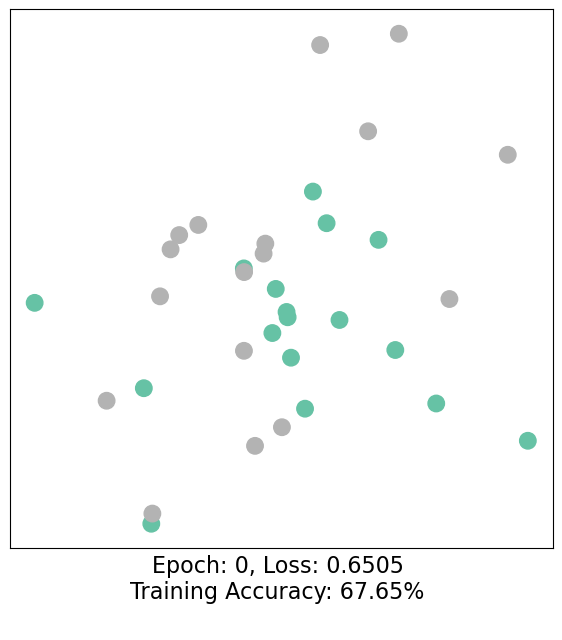

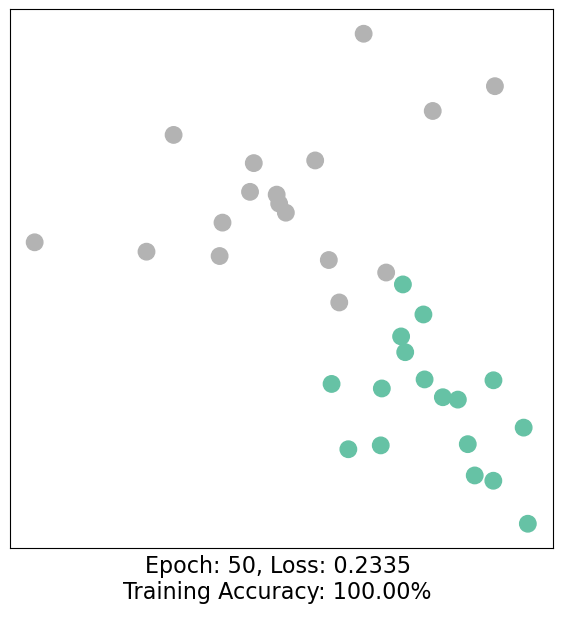

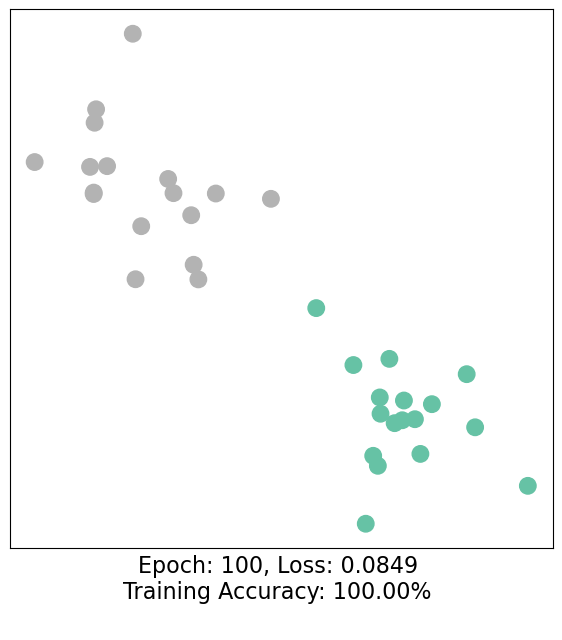

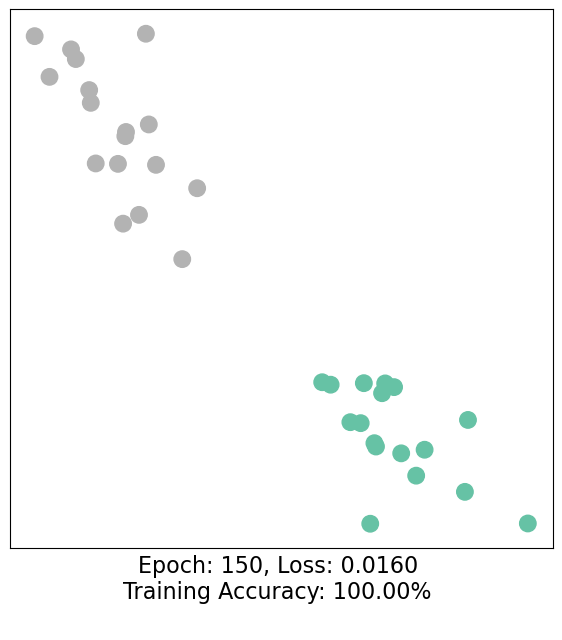

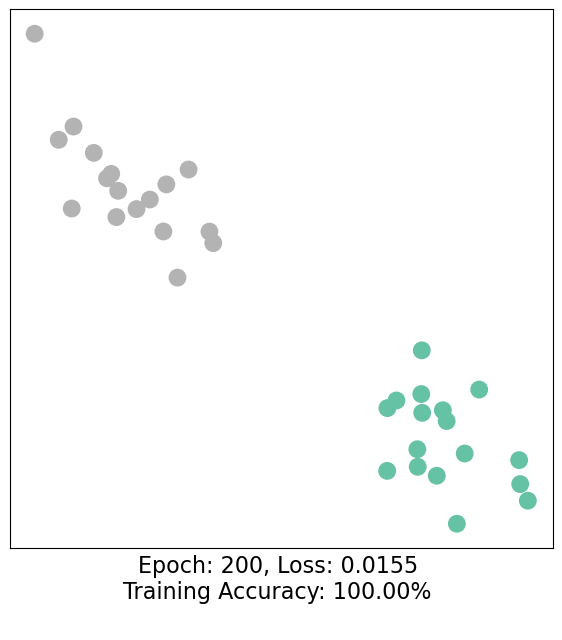

In [17]:
lr = 0.1
epochs = 250
CE = CrossEntropyLoss()

def train():
    for i in range(epochs):
        out0 = layersGAT[0].forward(V, A) # GAT 0 
        logits = layersGAT[1].forward(out0, A) # GAT 1
        loss = CE.forward(logits, y) # CrossEntropy

        dlogits = CE.backward(1) # CrossEntropy
        dH1, dW1, db1, dattention1, dskip_proj1 = layersGAT[1].backward(dlogits) #GCN 1
        dH0, dW0, db0, dattention0, dskip_proj0 = layersGAT[0].backward(dH1) #GCN 0

        layersGAT[1].W -= lr * dW1
        layersGAT[1].b -= lr * db1
        layersGAT[1].attention -= lr * dattention1
        layersGAT[1].skip_proj -= lr * dskip_proj1

        layersGAT[0].W -= lr * dW0
        layersGAT[0].b -= lr * db0
        layersGAT[0].attention -= lr * dattention0
        layersGAT[0].skip_proj -= lr * dskip_proj0

        acc = torch.mean(torch.where(torch.max(logits, dim = 1)[1] == y, 1.0, 0.0))

        if i % 50 == 0:
            visualize(logits, color=y, epoch=i, loss=loss, accuracy=acc)
            #time.sleep(0.3)
    
train()